<a href="https://colab.research.google.com/github/ImolaFodor/probabilistic-ML/blob/main/HW05_PML_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import sys
import json
import numpy as np
import torch
torch.set_default_dtype(torch.float64)
import sklearn
from sklearn.datasets import make_circles
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process as gp_sklearn
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt
import seaborn as sns

Let's consider a binary classification problem on Circles dataset. The input is two-dimensional and the response is binary
(0,1).
We observe 100 points 𝑥 from this dataset and their labels 𝑦:


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


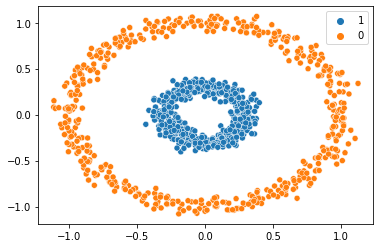

In [3]:
x, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()
def scatterplot(x, y):
 colors = np.array(['0', '1'])
 sns.scatterplot(x[:, 0], x[:, 1], hue=colors[y.int()])

scatterplot(x, y)

In [4]:
print(x)

tensor([[ 0.3206,  0.0016],
        [-0.0178, -0.2243],
        [-0.8052, -0.6622],
        ...,
        [-0.0020,  0.1970],
        [ 0.2506,  0.1839],
        [-0.2310,  0.1921]])


scikit-learn GaussianProcessClassifier
1. GaussianProcessClassifier from scikit-learn library [1] approximates the non-Gaussian posterior by a
Gaussian using Laplace approximation. Define an RBF kernel gp_sklearn.kernels.RBF with lenghtscale
parameter = 1 and fit a Gaussian Process classifier to the observed data (x,y).


In [5]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
                                random_state=0).fit(x, y)
gpc.score(x, y)

1.0

2. Use plot_sklearn_predictions function defined below to plot the posterior predictive mean function over a
finite grid of points. You should pass as inputs the learned GP classifier sklearn_gp_classifier , the observed
points x and their labels y .


In [6]:
def meshgrid(x, n, eps=0.1):
 x0, x1 = np.meshgrid(np.linspace(x[:, 0].min()-eps, x[:, 0].max()+eps, n),
 np.linspace(x[:, 1].min()-eps, x[:, 1].max()+eps, n))
 x_grid = np.stack([x0.ravel(), x1.ravel()], axis=-1)
 return x0, x1, x_grid
 
def plot_sklearn_predictions(sklearn_gp_classifier, x, y):
 x0, x1, x_grid = meshgrid(x, 30)
 preds = sklearn_gp_classifier.predict_proba(x_grid)
 preds_0 = preds[:,0].reshape(x0.shape)
 preds_1 = preds[:,1].reshape(x0.shape)
 plt.figure(figsize=(10,6))
 plt.contourf(x0, x1, preds_0, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.contourf(x0, x1, preds_1, 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.title(f'Posterior Mean')
 plt.xticks([]); plt.yticks([])
 plt.colorbar()
 scatterplot(x, y)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


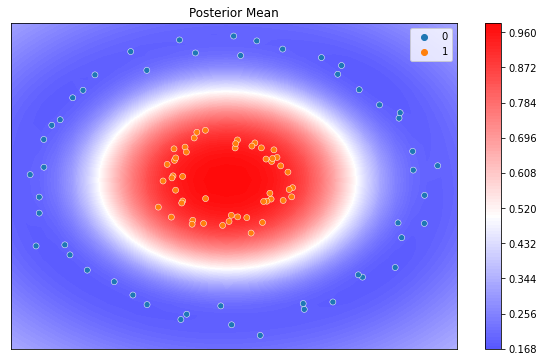

In [7]:
x_test, y_test = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test).double()

plot_sklearn_predictions(gpc, x_test, y_test)

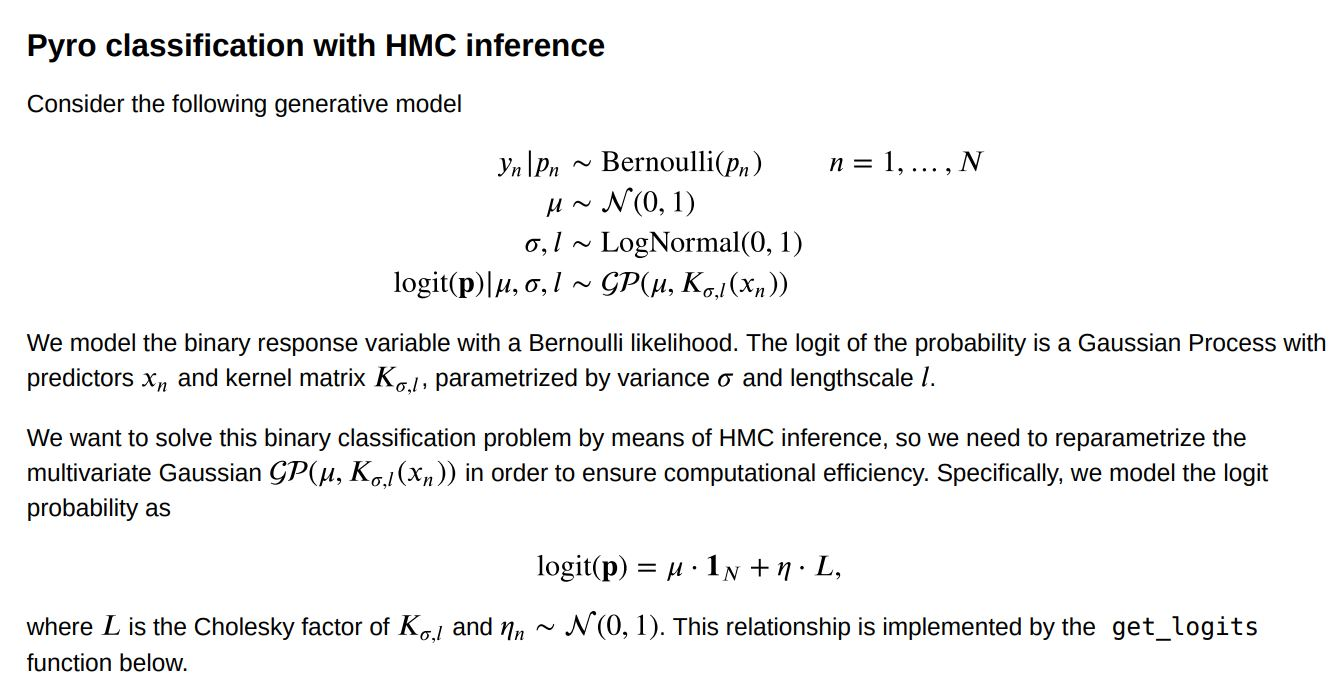

In [8]:
def get_logits(x, mu, sigma, l, eta):
 kernel = gp.kernels.RBF(input_dim=2, variance=torch.tensor(sigma), lengthscale=torch.tensor(l))
 K = kernel.forward(x, x) + torch.eye(x.shape[0]) * 1e-6
 L = K.cholesky()
 return mu+torch.mul(L,eta)

3. Write a pyro model gp_classifier(x,y) that implements the reparametrized generative model, using
get_logits function and pyro.plate on independent observations 𝑦𝑛
.

In [9]:
def logit2prob(logit):
  odds = torch.exp(logit)
  return odds / (1 + odds)

In [10]:
import pyro.distributions.constraints as constraints

def gp_classifier(x, y):
 eta = pyro.sample('eta', dist.Normal(0, 1))
 mean = pyro.sample("mu", dist.Uniform(1,2))
 sigma = pyro.sample("sigma", dist.Uniform(1,2))
 lengthscale = pyro.sample("l", dist.Uniform(1,2))
 logit = get_logits(x, mean, sigma, lengthscale, eta)
 pn = logit2prob(logit)
 with pyro.plate('components', 300):
   yn = pyro.sample('yn', dist.Bernoulli(probs = pn), obs = y)

4. Use pyro NUTS on the gp_classifier model to infer the posterior distribution of its parameters. Set
num_samples=10 and warmup_steps=50 . Then extract the posterior samples using pyro .get_samples()
and print the keys of this dictionary using .keys() method.

In [11]:
x, y = make_circles(n_samples=300, factor=0.3, noise=0.05, random_state=0)
x = torch.from_numpy(x)
y = torch.from_numpy(y).double()

print(gp_classifier(x, y))

kernel = NUTS(gp_classifier)
mcmc = MCMC(kernel, warmup_steps=50, num_samples=10, num_chains=1)
mcmc.run(x, y)
mcmc.summary()

posterior_samples = mcmc.get_samples()
keys = posterior_samples.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1337.)
  after removing the cwd from sys.path.


None


Sample: 100%|██████████| 60/60 [11:43, 11.73s/it, step size=1.44e-01, acc. prob=0.625]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       eta      0.60      0.13      0.53      0.46      0.79     19.76      0.94
         l      1.96      0.04      1.97      1.85      2.00      3.51      1.56
        mu      1.00      0.00      1.00      1.00      1.00      7.11      0.97
     sigma      1.54      0.23      1.58      1.10      1.82      9.12      1.04

Number of divergences: 0


The posterior_predictive function below outputs the prediction corresponding to the i-th sample from the posterior
distribution. plot_pyro_predictions calls this method to compute the average prediction on each input point and
plots the posterior predictive mean function over a finite grid of points.


In [12]:
def posterior_predictive(samples, i, x, x_grid):
 kernel = gp.kernels.RBF(input_dim=2, variance=samples['sigma'][i],lengthscale=samples['l'][i])
 N_grid = x_grid.shape[0]
 y = get_logits(x, samples['mu'][i], samples['sigma'][i],samples['l'][i], samples['eta'][i])

 with torch.no_grad():
  gpr = gp.models.GPRegression(x, y, kernel=kernel)
  mean, cov = gpr(x_grid, full_cov=True)

 yhat = dist.MultivariateNormal(mean, cov + torch.eye(N_grid) * 1e-6).sample()
 return yhat.sigmoid().numpy()

def plot_pyro_predictions(posterior_samples, x):
 n_samples = posterior_samples['sigma'].shape[0]
 x0, x1, x_grid = meshgrid(x, 300)
 x_grid = torch.from_numpy(x_grid)
 preds = np.stack([posterior_predictive(posterior_samples, i, x, x_grid) for i in range(n_samples)])
 plt.figure(figsize=np.array([10, 6]))
 plt.contourf(x0, x1, preds.mean(0).reshape(x0.shape), 101, cmap=plt.get_cmap('bwr'), vmin=0, vmax=1)
 plt.title(f'Posterior Mean')
 plt.xticks([]); plt.yticks([])
 plt.colorbar()
 scatterplot(x, y)

5. Pass the learned posterior samples obtained from NUTS inference and the set of training points x to
plot_pyro_predictions and plot the posterior predictive mean.


In [ ]:
plot_pyro_predictions(posterior_samples, x_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


References
[1] sklearn GP classifier (https://scikitlearn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)
[2] pyro GPs (https://pyro.ai/examples/gp.html)
